In [ ]:
import os 
import time 

start_time = time.time()  

# Get the path where data in YOLO format is put
yaml_path = os.path.abspath("dataset/field_data/data.yaml") 

# Train the YOLO model for object detection
train_command = f"yolo train model=yolov8n.pt data={yaml_path} epochs=50 batch=16 imgsz=640"
os.system(train_command) 

end_time = time.time() 
total_time = end_time - start_time 
# Document runtime
print(f"\nTotal Training time:{total_time:.2f} seconds. {total_time/60:.2f} minutes")

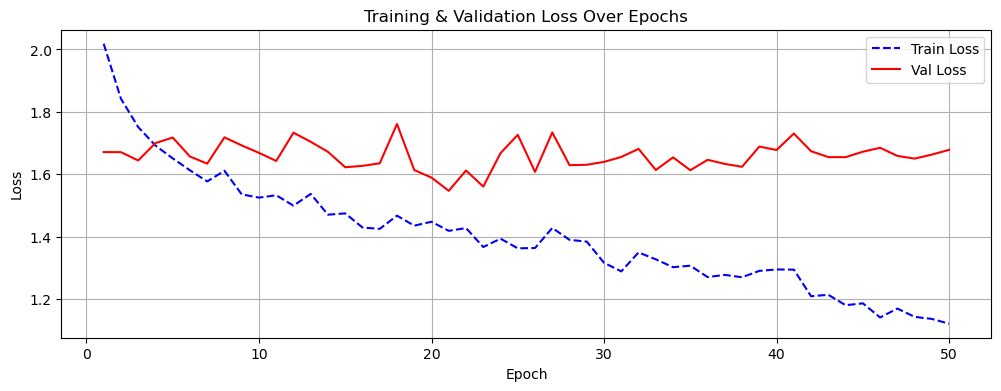

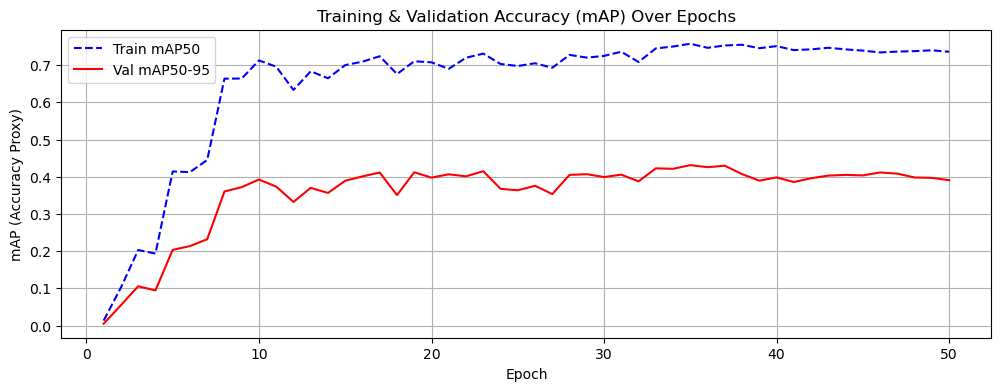

Final Training mAP50: 0.7360
Final Validation mAP50-95: 0.3908


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt

train_dir = "runs/detect/train2"
results_csv_path = os.path.join(train_dir, "results.csv")

# Load CSV data
df = pd.read_csv(results_csv_path)

df.columns = df.columns.str.strip().str.replace(r'\s+', ' ', regex=True)

# Extract metrics
epochs = df["epoch"]
train_loss = df["train/box_loss"]
val_loss = df["val/box_loss"]
train_accuracy = df["metrics/mAP50(B)"]  # mAP at IoU 0.5
val_accuracy = df["metrics/mAP50-95(B)"]  # mAP at IoU 0.5-0.95

# Plot Loss Over Epochs
plt.figure(figsize=(12, 4))
plt.plot(epochs, train_loss, label="Train Loss", color="blue", linestyle="--")
plt.plot(epochs, val_loss, label="Val Loss", color="red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

# Plot Accuracy Over Epochs
plt.figure(figsize=(12, 4))
plt.plot(epochs, train_accuracy, label="Train mAP50", color="blue", linestyle="--")
plt.plot(epochs, val_accuracy, label="Val mAP50-95", color="red")
plt.xlabel("Epoch")
plt.ylabel("mAP (Accuracy Proxy)")
plt.title("Training & Validation Accuracy (mAP) Over Epochs")
plt.legend()
plt.grid()
plt.show()

# Print final metrics
final_train_mAP50 = train_accuracy.iloc[-1]  # Last epoch's train accuracy
final_val_mAP50 = val_accuracy.iloc[-1]  # Last epoch's val accuracy

print(f"Final Training mAP50: {final_train_mAP50:.4f}")
print(f"Final Validation mAP50-95: {final_val_mAP50:.4f}")


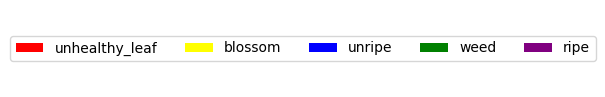


image 1/1 /home/larizmen/cs229/CS229Project/CNNExpirement/dataset/field_data/val/IMG_7416.jpg: 480x640 2 unripes, 11.0ms
Speed: 2.6ms preprocess, 11.0ms inference, 7.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/larizmen/cs229/CS229Project/CNNExpirement/dataset/field_data/val/IMG_7251.jpg: 640x480 7 unhealthy_leafs, 5 blossoms, 5 unripes, 11.9ms
Speed: 2.9ms preprocess, 11.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /home/larizmen/cs229/CS229Project/CNNExpirement/dataset/field_data/val/IMG_7380.jpg: 640x480 3 unhealthy_leafs, 4 blossoms, 1 unripe, 3 weeds, 10.1ms
Speed: 3.5ms preprocess, 10.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /home/larizmen/cs229/CS229Project/CNNExpirement/dataset/field_data/val/IMG_7410.jpg: 640x480 (no detections), 9.2ms
Speed: 4.7ms preprocess, 9.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /home/larizmen/cs229/CS229Project/CNNEx

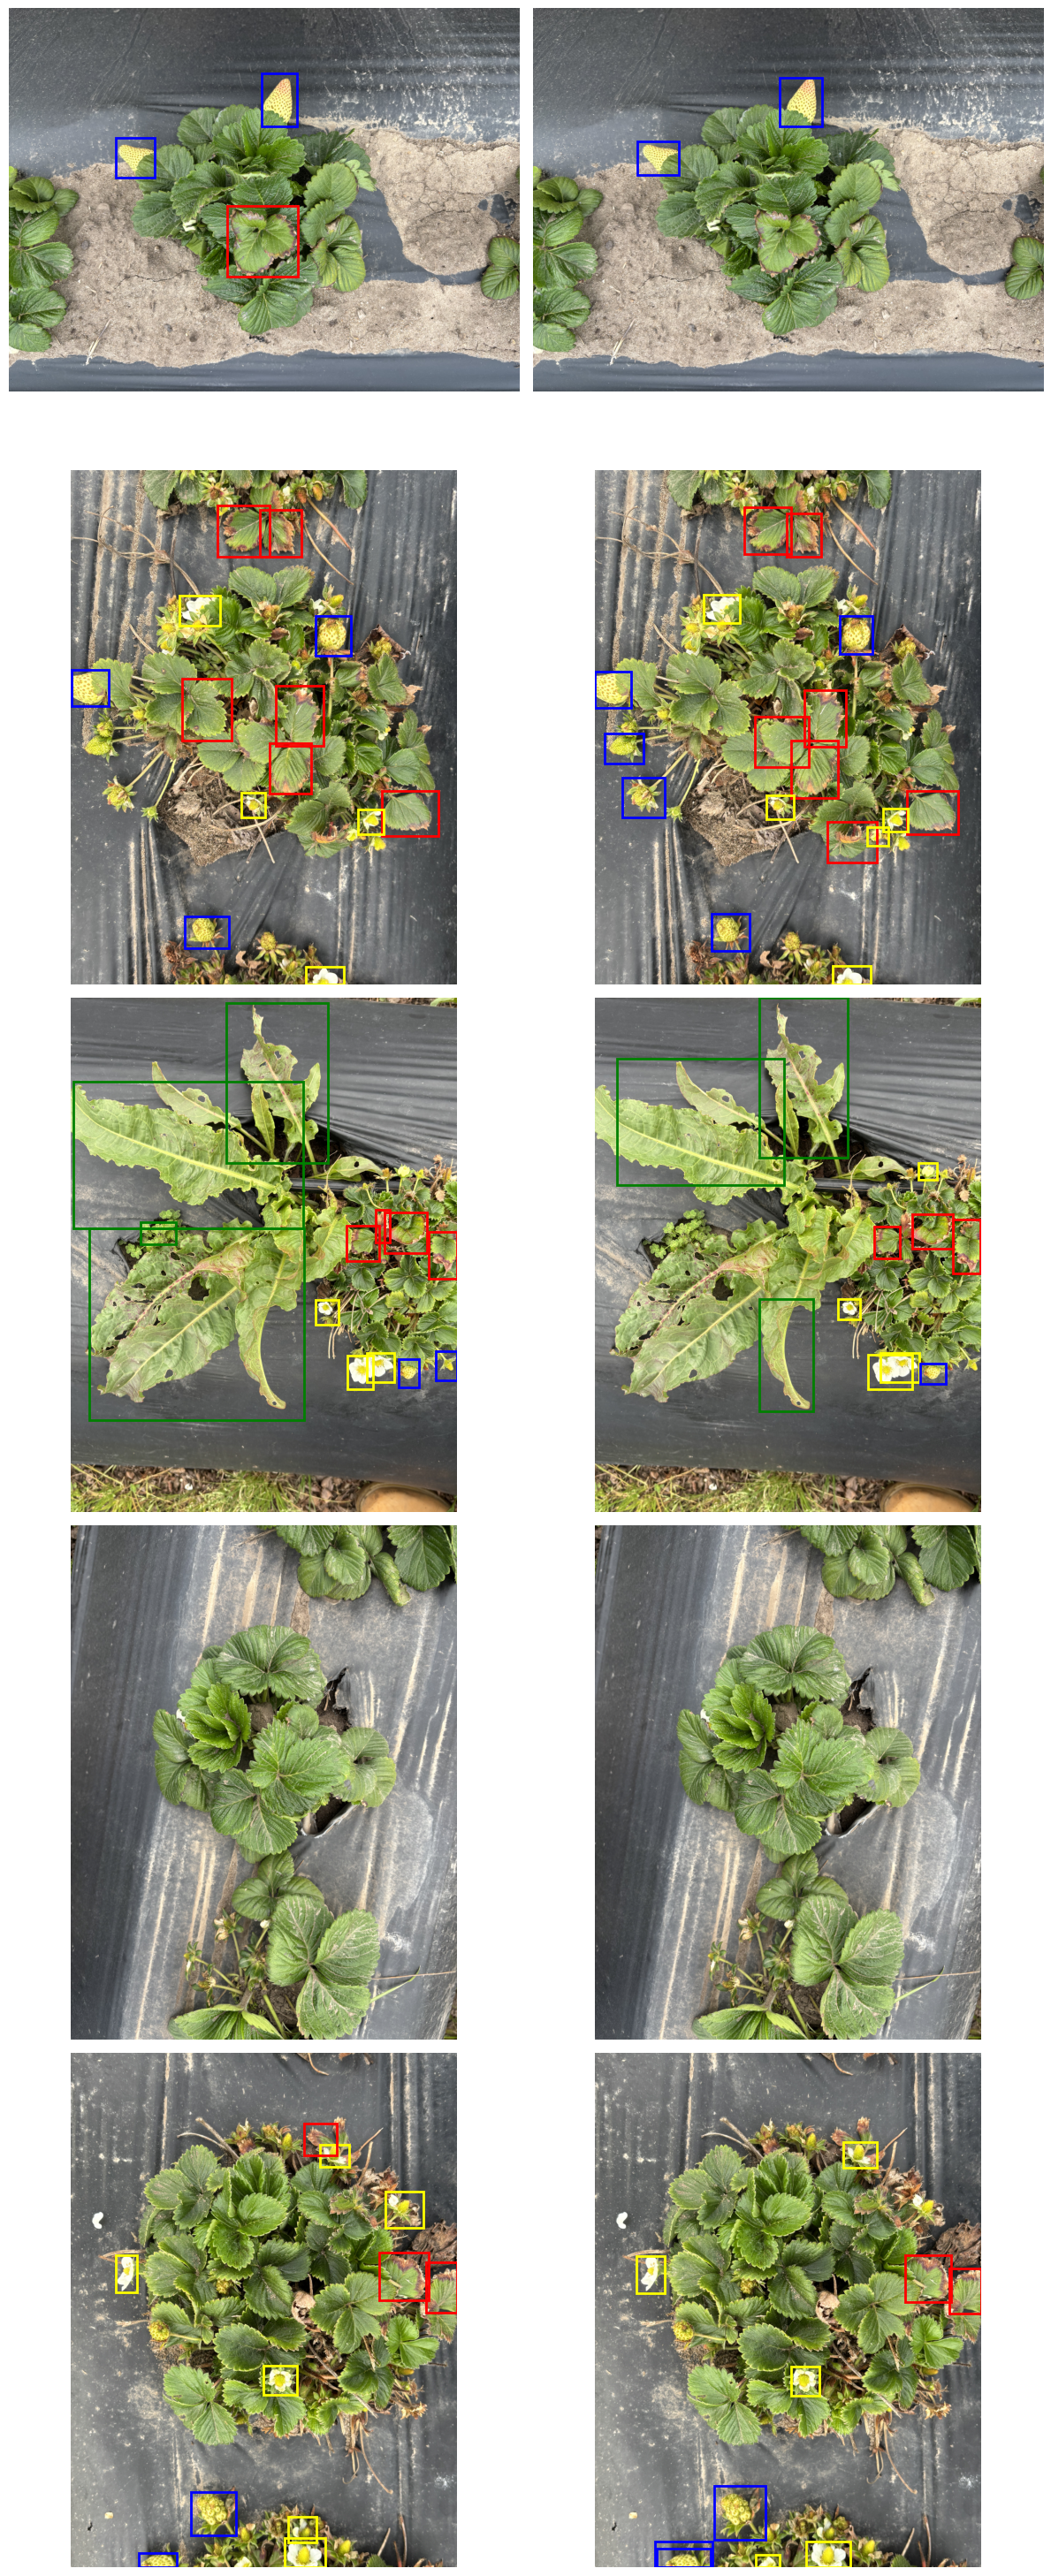

In [ ]:
import os
import random
import cv2
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from ultralytics import YOLO

image_dir = "dataset/field_data/val"
label_dir = "dataset/field_data/val"

test_images = [f for f in os.listdir(image_dir) if f.endswith((".jpg", ".JPG"))]
num_samples = 5 # Change to change number of sample predictions 
selected_images = random.sample(test_images, min(num_samples, len(test_images)))

# Legend
class_colors = {
    "unhealthy_leaf": "red",
    "blossom": "yellow",
    "unripe": "blue",
    "weed": "green",
    "ripe": "purple"
}

fig_legend, ax_legend = plt.subplots(figsize=(6, 1))
legend_patches = [patches.Patch(facecolor=color, label=cls) for cls, color in class_colors.items()]
ax_legend.legend(handles=legend_patches, loc="center", ncol=len(class_colors))
ax_legend.axis("off")
plt.show()

fig, axes = plt.subplots(num_samples, 2, figsize=(12, 6 * num_samples))

for i, img_name in enumerate(selected_images):
    img_path = os.path.join(image_dir, img_name)
    label_path = os.path.join(label_dir, img_name.replace(".jpg", ".txt").replace(".JPG", ".txt"))

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = model(img_path)[0]
    img_pred = img.copy()

    ax_pred = axes[i, 1]
    ax_pred.imshow(img_pred)

    for j in range(len(results.boxes.xyxy)):
        x1, y1, x2, y2 = map(int, results.boxes.xyxy[j].tolist())
        class_id = int(results.boxes.cls[j].item())
        class_name = results.names[class_id]
        color = class_colors.get(class_name, "white")

        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor=color, facecolor="none")
        ax_pred.add_patch(rect)

    img_gt = img.copy()
    ax_gt = axes[i, 0]
    ax_gt.imshow(img_gt)

    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f.readlines():
                data = line.strip().split()
                if len(data) == 5:
                    class_id, x_center, y_center, width, height = map(float, data)
                    class_id = int(class_id)
                    class_name = list(class_colors.keys())[class_id]
                    color = class_colors.get(class_name, "white")

                    x1 = int((x_center - width / 2) * img.shape[1])
                    y1 = int((y_center - height / 2) * img.shape[0])
                    x2 = int((x_center + width / 2) * img.shape[1])
                    y2 = int((y_center + height / 2) * img.shape[0])

                    rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor=color, facecolor="none")
                    ax_gt.add_patch(rect)
    ax_gt.axis("off")
    ax_pred.axis("off")

plt.tight_layout()
plt.show()
